In [1]:
import torch
from torch.nn.functional import conv2d
from time import time
import json
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

input – input tensor of shape ($minibatch , in\_channels , iH , iW)$

weight – filters of shape ($out\_channels$ , $in\_channels$ , kH , kW)

In [3]:
!ls build/

CMakeCache.txt	     conv2d.backward.json  Makefile
CMakeFiles	     conv2d.forward.json   pretty.json
cmake_install.cmake  main		   result_forward.json


In [4]:
def get_result(file_name):
    base_dir = Path("build/")
    with Path(base_dir, "conv2d.forward.json").open("r") as f:
        return json.load(f)

In [5]:
bs = 1
in_channels = 4
out_channels = 4
iH = 100
iW = 100
kH = 3
kW = 3

def forward(bs=1, in_channels=64, out_channels=64, iH=128, iW=128, kH=3, kW=3):
    t = torch.randn(bs, in_channels, iH, iW)
    weight = torch.randn(out_channels, in_channels, kH, kW)
    bias = torch.randn(out_channels)
    start = time()
    conv2d(t, weight, bias)
    return time() - start
    
def backward(bs=1, in_channels=64, out_channels=64, iH=128, iW=128, kH=3, kW=3):
    t = torch.autograd.Variable(torch.randn(bs, in_channels, iH, iW), requires_grad=True)
    weight = torch.autograd.Variable(torch.randn(out_channels, in_channels, kH, kW), requires_grad=True)
    bias = torch.autograd.Variable(torch.randn(out_channels), requires_grad=True)
   
    output = conv2d(t, weight, bias)
    start = time()
    output.backward(output)
    return  time() - start

### Test forward

In [6]:
%%timeit
forward()

21.2 ms ± 675 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
nn_forward = get_result("conv2d.forward.json")
print(nn_forward)

{'bs': [[1, 1.607328569]], 'iH': [[3, 0.000129072], [32, 0.089252408], [64, 0.379259478], [128, 1.545754086]], 'in_channels': [[1, 0.025464135], [3, 0.071451961], [10, 0.235381175], [64, 1.563686531]], 'kH': [[1, 0.58542726], [3, 1.571845604], [7, 3.696721137]], 'out_channels': [[1, 0.027282052], [3, 0.076728835], [10, 0.249823913], [64, 1.724337663]]}


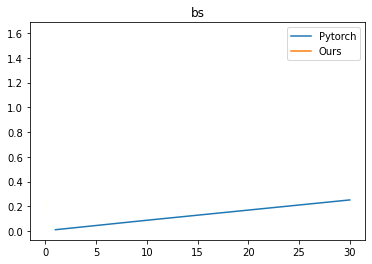

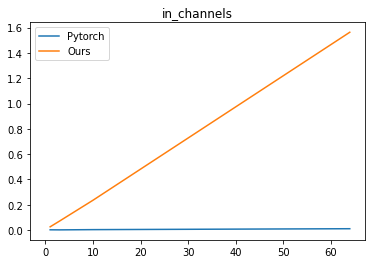

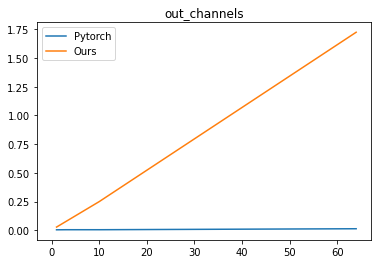

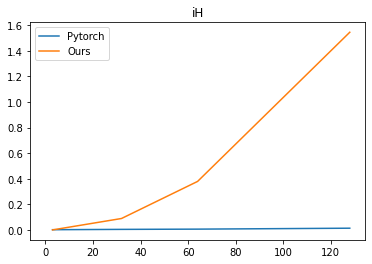

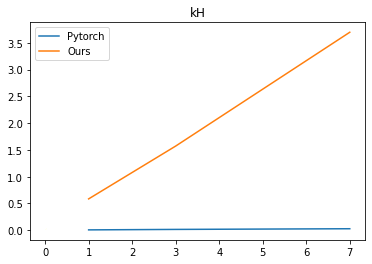

In [8]:
benchmark = {
    "bs": [1, 10, 30],
    "in_channels": [1, 3, 10, 64],
    "out_channels": [1, 3, 10, 64],
    "iH": [3, 32, 64, 128],
    "kH": [1, 3, 7]
}
N = 3 # 3 random
for key in benchmark:
    times = [[forward(**{key: value}) for value in benchmark[key]] for _ in range(N)]
    times = np.stack(times)
    mean, std = times.mean(0), times.std(0)

    f, axis = plt.subplots(1, 1)
    axis.plot(benchmark[key], mean, label="Pytorch")
    axis.fill_between(mean, mean - std, mean + std, facecolor='yellow', alpha=0.5)
    axis.set_title(key)
    
    axis.plot([kv[0] for kv in nn_forward[key]], [kv[1] for kv in nn_forward[key]], label="Ours")
    plt.legend()
    plt.show()

### Test backward

In [10]:
%%timeit
backward()

43.4 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
nn_backward = get_result("conv2d.backward.json")
print(nn_backward)

{'bs': [[1, 1.607328569]], 'iH': [[3, 0.000129072], [32, 0.089252408], [64, 0.379259478], [128, 1.545754086]], 'in_channels': [[1, 0.025464135], [3, 0.071451961], [10, 0.235381175], [64, 1.563686531]], 'kH': [[1, 0.58542726], [3, 1.571845604], [7, 3.696721137]], 'out_channels': [[1, 0.027282052], [3, 0.076728835], [10, 0.249823913], [64, 1.724337663]]}


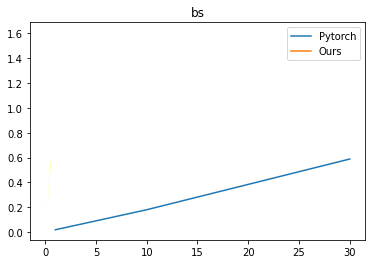

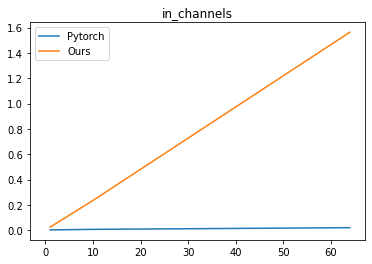

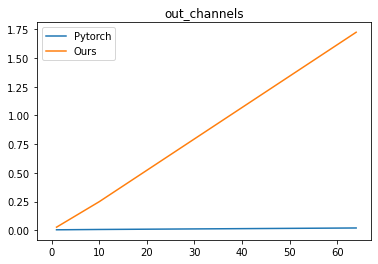

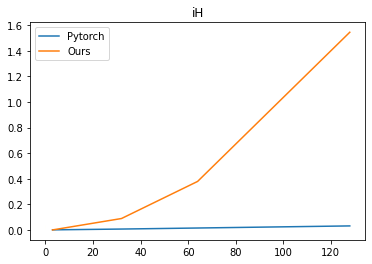

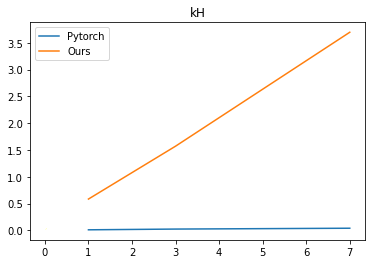

In [12]:
benchmark = {
    "bs": [1, 10, 30],
    "in_channels": [1, 3, 10, 64],
    "out_channels": [1, 3, 10, 64],
    "iH": [3, 32, 64, 128],
    "kH": [1, 3, 7]
}
N = 3 # 3 random
for key in benchmark:
    times = [[backward(**{key: value}) for value in benchmark[key]] for _ in range(N)]
    times = np.stack(times)
    mean, std = times.mean(0), times.std(0)

    f, axis = plt.subplots(1, 1)
    axis.plot(benchmark[key], mean, label="Pytorch")
    axis.fill_between(mean, mean - std, mean + std, facecolor='yellow', alpha=0.5)
    axis.set_title(key)
    
    axis.plot([kv[0] for kv in nn_backward[key]], [kv[1] for kv in nn_backward[key]], label="Ours")
    plt.legend()
    plt.show()